# Лабораторная работа 2. Вероятностные модели.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов. Также в результате выполнения заданий у вас получится решение [задачи конкурса](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021), которое после небольшой доработки принесёт ещё 5 баллов за пробитие Medium Baseline.
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировками
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.


Цель этой лабораторной работы – научиться строить вероятностные модели и оптимизировать их параметры на примере задачи оценки риска заболевания сахарным диабетом. На задачу оценки риска болезни мы посмотрим со стороны страховой компании.

Если человек перестанет проходить обследования, и страховая так и не узнает, развился ли у него диабет, то и расходов, связанных с его заболеванием не будет, т.е. можно считать, что такой человек остался здоров. То же касается людей, у которых заболевание впервые обнаружат более чем через 5 лет.

Чтобы рассчитать математическое ожидание затрат на лечение клиента, страховая хочет получить в качестве результата работы модели непосредственно вероятность того, что у человека, не страдающего от заболевания, оно разовьётся в течение 5 лет. Поэтому в качестве метрики качества была выбрана бинарная кросс-энтропия (она же logloss) между предсказанными вероятностями и истинными метками классов:


$$\text{crossentropy}(y, p) = -\frac{1}{N}\sum_{i=1}^N\left[y_i\log(p_i) + (1-y_i)\log(1-p_i)\right]$$



**Задание 1** Препроцессинг (1 балл) 

- Прочитайте описание [набора данных и задачи конкурса 2](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021).
- Загрузите обучающий набор данных (X_train.csv, y_train.csv).
- Обратите внимание, что часть информации о клиентах неизвестна на момент заключения договора. Соответствующие признаки отсутствуют в X_test.csv.
- Заполните пропуски в данных. Для этого могут пригодиться методы из sklearn.impute или pandas.DataFrame.fillna.
- По желанию используйте любой препроцессинг данных, добавляйте новые признаки и т.п. ваша задача — добиться сходимости и высокого качества полученных моделей.
- Разбейте обучающую выборку на lab_train и lab_test, которые будете использовать для оценки всех построенных моделей в лабораторной работе. При желании использовать для оценки качества кросс-валидацию необходимо проконтролировать, чтобы для всех моделей использовались одни и те же разбиения.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

path = 'drive/MyDrive/ml/lab-2'
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')

In [3]:
X_train.head()

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,Triglyceride,High-density lipoprotein cholesterol,Low-density lipoprotein cholesterol,Alanine aminotransferase,Aspartate transaminase,Blood urea nitrogen,Creatinine clearance rate,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup,smoking status,drinking status,family history of diabetes
0,53,1,13,163.5,64.1,24.00,106.0,68.0,4.83,3.84,1.35,1.16,2.34,15.9,NaN,5.01,74.8,5.23,NaN,0,2.699521,3.0,3.0,0
1,26,2,3,156.0,68.5,28.10,98.0,68.0,5.12,4.12,0.72,NaN,NaN,12.6,15.3,3.19,54.7,4.33,NaN,0,2.187543,3.0,3.0,0
2,40,2,5,152.0,47.0,20.30,111.0,63.0,5.62,4.30,0.70,1.32,2.73,14.0,17.0,4.38,66.0,4.70,NaN,0,2.042437,3.0,3.0,0
3,34,1,4,177.0,68.0,21.71,133.0,81.0,4.84,4.35,1.39,NaN,NaN,31.8,26.5,5.79,78.9,5.69,NaN,0,2.028747,NaN,NaN,0
4,34,1,3,178.0,68.0,21.50,124.0,84.0,3.73,5.02,1.12,NaN,NaN,29.6,NaN,3.68,76.9,5.00,NaN,0,4.950034,3.0,3.0,0


In [4]:
y_train.head()

,Id,diabettes in 5 years
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [6]:
X_train.isna().mean()

Age                                      0.00000
Gender                                   0.00000
site                                     0.00000
height                                   0.00002
weight                                   0.00000
Body Mass Index                          0.00000
Systolic blood pressure                  0.00011
diastolic blood pressure                 0.00012
Fasting plasma glucose                   0.00000
Cholesterol                              0.02257
Triglyceride                             0.02277
High-density lipoprotein cholesterol     0.44444
Low-density lipoprotein cholesterol      0.43884
Alanine aminotransferase                 0.00837
Aspartate transaminase                   0.58247
Blood urea nitrogen                      0.10080
Creatinine clearance rate                0.05200
Fasting plasma glucose (final visit)     0.00009
Diabetes diagnosed during followup       0.99381
censor of diabetes at followup           0.00000
year of followup    

In [7]:
# Заполним пропуски в столбце Diabetes diagnosed during followup нулями,
# чтобы считать, что заболевание не было выявлено
X_train['Diabetes diagnosed during followup'].fillna(0, inplace=True)

In [8]:
from sklearn.model_selection import train_test_split

lab_train, lab_test, lab_y_train, lab_y_test = train_test_split(X_train, y_train['diabettes in 5 years'], train_size=0.8, random_state=42)

In [9]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
lab_train = imputer.fit_transform(lab_train)

lab_train = pd.DataFrame(lab_train, columns=X_train.columns)
lab_train.head()

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,Triglyceride,High-density lipoprotein cholesterol,Low-density lipoprotein cholesterol,Alanine aminotransferase,Aspartate transaminase,Blood urea nitrogen,Creatinine clearance rate,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup,smoking status,drinking status,family history of diabetes
0,57.0,1.0,5.0,175.0,75.0,24.5,152.0,103.0,6.60,5.10,2.20,1.83,2.66,21.0,22.0,3.30,71.0,7.00,1.0,1.0,3.863107,3.0,3.0,0.0
1,48.0,2.0,9.0,164.0,53.2,19.8,118.0,54.0,4.50,3.70,1.15,1.34,2.70,27.7,22.0,3.20,55.4,4.60,0.0,0.0,2.472279,3.0,3.0,0.0
2,42.0,2.0,2.0,163.0,63.5,23.9,136.0,85.0,5.10,3.60,0.93,1.34,2.70,14.8,22.0,5.60,65.4,6.10,0.0,0.0,2.702259,3.0,3.0,0.0
3,43.0,2.0,5.0,160.0,59.0,23.0,112.0,89.0,4.52,3.87,1.00,1.55,1.89,12.0,20.0,4.55,49.0,5.40,0.0,0.0,4.043806,3.0,3.0,0.0
4,30.0,1.0,9.0,179.0,64.0,20.0,107.0,65.0,4.98,6.30,1.26,1.34,2.70,18.1,22.0,4.58,71.5,5.23,0.0,0.0,2.770705,3.0,3.0,0.0


In [10]:
lab_y_train = pd.DataFrame(lab_y_train, columns=['diabettes in 5 years'])
lab_y_train.head()

,diabettes in 5 years
75220,1
48955,0
44966,0
13568,0
92727,0


In [11]:
lab_test = imputer.transform(lab_test)

lab_test = pd.DataFrame(lab_test, columns=X_train.columns)
lab_test.head()

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,Triglyceride,High-density lipoprotein cholesterol,Low-density lipoprotein cholesterol,Alanine aminotransferase,Aspartate transaminase,Blood urea nitrogen,Creatinine clearance rate,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup,smoking status,drinking status,family history of diabetes
0,35.0,2.0,4.0,147.0,42.0,19.4,121.0,98.0,4.58,4.35,1.71,1.29,2.46,14.0,20.0,4.53,47.6,5.01,0.0,0.0,3.846680,3.0,3.0,0.0
1,55.0,2.0,5.0,157.0,56.0,22.7,107.0,60.0,4.10,6.10,1.70,1.39,4.02,29.0,31.0,3.52,58.0,5.70,0.0,0.0,2.477755,3.0,3.0,0.0
2,63.0,2.0,2.0,157.0,64.0,26.0,122.0,80.0,5.08,6.18,2.48,1.20,3.75,10.3,22.0,2.71,52.1,5.80,0.0,0.0,2.606434,3.0,3.0,0.0
3,34.0,1.0,5.0,171.0,74.0,25.3,112.0,74.0,4.68,4.10,2.40,1.34,2.70,67.0,44.0,4.80,84.0,5.30,0.0,0.0,3.728953,3.0,3.0,0.0
4,47.0,1.0,14.0,167.5,60.3,21.5,118.0,75.0,5.30,4.05,0.58,1.34,2.70,27.0,14.8,4.53,69.4,5.06,0.0,0.0,2.004107,3.0,3.0,0.0


In [12]:
lab_y_test = pd.DataFrame(lab_y_test, columns=['diabettes in 5 years'])
lab_y_test.head()

,diabettes in 5 years
75721,0
80184,0
19864,0
76699,0
92991,0


In [64]:
unavailable_features = ['year of followup', 'Fasting plasma glucose (final visit)', 'Diabetes diagnosed during followup', 'censor of diabetes at followup']
lab_train_2 = lab_train.drop(columns=unavailable_features)
lab_test_2 = lab_test.drop(columns=unavailable_features)

В данном пункте я заполнила пропуски в столбце `Diabetes diagnosed during followup` нулями, чтобы считать, что заболевание не было выявлено (это не противоречит данным), после разбила выборку на обучение и тест, заполнила пропуски в обучающей выборке медианными значениями, а после заполнила тест. Заполнять пропущенные значения до того, как был бы разбит датасет, не правильно, так как пропущенные данные во всем датасете учитывали бы и тестовую выборку.

**Задание 2** Бэйзлайн – константное предсказание (0.5 балла).

Как понять, работает ли та или иная модель, если сравить метрику не с чем? Чтобы было с чем сравнивать, соберём простой бэйзлайн: предскажем всем клиентам одну и ту же вероятность заболеть в течение 5 лет. Какое значение надо предсказать, чтобы минимизировать кросс-энтропию? Оцените качество такого предсказания.

**Решение:**
$$\text{crossentropy}(y, p) = -\frac{1}{N}\sum_{i=1}^N\left[y_i\log(p) + (1-y_i)\log(1-p)\right]$$

$$\frac{\partial\text{crossentropy}(y, p)}{\partial p} = -\frac{1}{N}\sum\limits_{i=1}^{N}\left[\frac{y_i}{p} - \frac{1-y_i}{1-p}\right] = -\frac{1}{N}\sum\limits_{i=1}^{N}\left[\frac{y_i(1-p)-(1-y_i)p}{p(1-p)}\right] = -\frac{1}{N}\sum\limits_{i=1}^{n}\left[\frac{y_i - p}{p(1-p)} \right] = 0$$

$$\sum\limits_{i=1}^{N} y_i - np = 0 => p = \frac{1}{n} \sum\limits_{i=1}^{N}y_i$$

In [13]:
%pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.1)


In [ ]:
import sklearn
print('sklearn: {}'.format(sklearn.__version__))

sklearn: 0.24.1


In [ ]:
p = lab_y_train['diabettes in 5 years'].mean()
print("Оценка вероятности p = ", p)

Оценка вероятности p =  0.0187


In [ ]:
from sklearn.metrics import log_loss

train_prob = np.array([[1 - p, p] for _ in range(lab_y_train.shape[0])])
print("crossentropy на train:", log_loss(lab_y_train.values, train_prob))

crossentropy на train: 0.09293568864756983


In [ ]:
test_prob = np.array([[1 - p, p] for _ in range(lab_y_test.shape[0])])
print("crossentropy на test:", log_loss(lab_y_test.values, test_prob))

crossentropy на test: 0.09016344035802348


**Задание 3** Наивный байесовский классификатор (0.5 балла).

Предположим, что в каждом из классе признаки независимы и имеют нормальное распределение. Тогда подобрать параметры этого распределения поможет модель [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). Обучите эту модель. Оцените её качество.





In [ ]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(lab_train, lab_y_train['diabettes in 5 years'])
y_prob = clf.predict_proba(lab_test)

print("GNB на всех признаках")
print("crossentropy: ", log_loss(lab_y_test, y_prob))

GNB на всех признаках
crossentropy:  0.039719592854148285


In [ ]:
clf = GaussianNB()
clf.fit(lab_train_2, lab_y_train['diabettes in 5 years'])
y_prob = clf.predict_proba(lab_test_2)

print("GNB на всех признаках, кроме тех, которых нет для y_test")
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'], y_prob))

GNB на всех признаках, кроме тех, которых нет для y_test
crossentropy:  0.4773981850536331


На всех данных признаках наивный байесовский классификатор имеет меньшую кроссэнтропию, чем на признаках, которых нет для тестовой части выборки (в дальнейшем я буду их называть дополнительными признаками). В первом случае кроссэнтропия меньше,потому что обнаружение заболевания зависит от дополнительных признаков, которые позволяют точно предсказать заболевание. Мы же всё таки хотим строить модель без дополнительных признаков, потому что они отстутствуют для людей, для которых мы бы хотели предсказать заболевание.

**Задание 4** Дискриминантный анализ (1 балл).

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_lda_qda_001.png)

Теперь избавимся от предположения условной независимости признаков относительно целевой переменной. Таким образом, ковариационные матрицы распределений классов не обязательно будут даигональны. Мы можем наложить дополнительное условие в виде [равенства ковариационных матриц](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis) всех классов или [не делать этого](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis).

Попробуйте оба варианта. Какой сработал лучше и чем это можно объяснить?


**LinearDiscriminantAnalysis**


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(lab_train_2, lab_y_train['diabettes in 5 years'])
y_proba = lda.predict_proba(lab_test_2)

print("LDA c SVD разложением на всех признаках, кроме тех, которых нет для y_test")
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'], y_proba))

LDA c SVD разложением на всех признаках, кроме тех, которых нет для y_test
crossentropy:  0.06296573079510763


In [ ]:
from sklearn.covariance import LedoitWolf

lda = LinearDiscriminantAnalysis(solver='lsqr',
                                 covariance_estimator=LedoitWolf())
lda.fit(lab_train_2, lab_y_train['diabettes in 5 years'])
y_proba = lda.predict_proba(lab_test_2)

print("LDA c covariance_estimator=LedoitWolf на всех признаках, кроме тех, которых нет для y_test")
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'], y_proba))

LDA c covariance_estimator=LedoitWolf на всех признаках, кроме тех, которых нет для y_test
crossentropy:  0.06270498168000126


**QuadraticDiscriminantAnalysis**

In [ ]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(lab_train_2, lab_y_train['diabettes in 5 years'])
y_proba = qda.predict_proba(lab_test_2)

print("QDA на всех признаках, кроме тех, которых нет для y_test")
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'], y_proba))

QDA на всех признаках, кроме тех, которых нет для y_test
crossentropy:  0.38161180847470794


**Вывод:** Будем оценивать модели, построенные без дополнительных признаков. Наименьшая кроссэнтропия получилась у LDA. Это можно объяснить тем, что LDA использует одинаковую ковариационную матрицу для обоих классов (в отличие от QDA). Но почему это так важно? Признаки, по которым мы хотим предсказать диабет в будущем, взяты у здоровых людей и скорее всего они будут "схожи".

**Задание 5** Логистическая регрессия (1 балл).

Обучите модель логистической регрессии. Убедитесь, что модель сошлась. Удалось ли получить улучшение по сравнению с предыдущими моделями? Чем это можно объяснить?

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1e4)
lr.fit(lab_train, lab_y_train['diabettes in 5 years'])

y_proba = lr.predict_proba(lab_test)
print("Логистическая регрессия на всех признаках")
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'], y_proba))

Логистическая регрессия на всех признаках
crossentropy:  0.0022322464257775536


In [ ]:
lr = LogisticRegression(max_iter=1e4)
lr.fit(lab_train_2, lab_y_train['diabettes in 5 years'])

y_proba = lr.predict_proba(lab_test_2)
print("Логистическая регрессия на всех признаках, кроме тех, которых нет для y_test")
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'], y_proba))

Логистическая регрессия на всех признаках, кроме тех, которых нет для y_test
crossentropy:  0.060276390289730725


**Вывод:** Логистическая регрессия дает улучшение по сравнению с предыдущими моделями (но не сильно). 

**Задание 6** GLM – обобщённые линейные модели (1 балл).

Как вы знаете, логистическая регрессия является частным случаем обобщённой линейной модели $\mu(\mathbb E(y|X)) = Xw$, где функция связи $\mu(u) = \log(\frac{u}{1-u})$, и $y|X\sim Bernoulli$.

Учитывая, что целевая переменная бинарная, изменять класс распределений $y|X$ не имеет смысла. А вот изменить функцию связи можно.

Обучите обобщённые линейные модели, в качестве функции связи использовав по крайней мере 2 разные функции, отличные от logit, использующейся в логистической регрессии.

Реализацию GLM можно взять в пакете [statsmodels](https://www.statsmodels.org/stable/glm).



In [ ]:
import statsmodels.api as sm

model = sm.GLM(lab_y_train['diabettes in 5 years'].values, lab_train_2,
               family=sm.families.Binomial(link=sm.families.links.logit()))
model_results = model.fit()
print(model_results.summary())

y_proba = model_results.predict(lab_test_2)
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'], y_proba))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                80000
Model:                            GLM   Df Residuals:                    79980
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4992.9
Date:                Tue, 30 Mar 2021   Deviance:                       9985.9
Time:                        19:03:13   Pearson chi2:                 1.42e+05
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [ ]:
link = link=sm.families.links.probit()
model = sm.GLM(lab_y_train['diabettes in 5 years'].values, lab_train_2,
                        family=sm.families.Binomial(link=link))
model_results = model.fit()
print(model_results.summary())

y_proba = model_results.predict(lab_test_2)
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'], y_proba))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                80000
Model:                            GLM   Df Residuals:                    79980
Model Family:                Binomial   Df Model:                           19
Link Function:                 probit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5028.8
Date:                Tue, 30 Mar 2021   Deviance:                       10058.
Time:                        19:03:15   Pearson chi2:                 1.90e+06
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [ ]:
link = link=sm.families.links.cloglog()
model = sm.GLM(lab_y_train['diabettes in 5 years'].values, lab_train_2,
                        family=sm.families.Binomial(link=link))
model_results = model.fit()
print(model_results.summary())

y_proba = model_results.predict(lab_test_2)
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'].values, y_proba))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                80000
Model:                            GLM   Df Residuals:                    79980
Model Family:                Binomial   Df Model:                           19
Link Function:                cloglog   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5020.7
Date:                Tue, 30 Mar 2021   Deviance:                       10041.
Time:                        19:03:17   Pearson chi2:                 1.07e+05
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [ ]:
link = link=sm.families.links.cauchy()
model = sm.GLM(lab_y_train['diabettes in 5 years'].values, lab_train_2,
                        family=sm.families.Binomial(link=link))
model_results = model.fit()
print(model_results.summary())

y_proba = model_results.predict(lab_test_2)
print("crossentropy: ", log_loss(lab_y_test['diabettes in 5 years'].values, y_proba))

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                80000
Model:                            GLM   Df Residuals:                    79980
Model Family:                Binomial   Df Model:                           19
Link Function:                 cauchy   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5804.1
Date:                Tue, 30 Mar 2021   Deviance:                       11608.
Time:                        19:03:26   Pearson chi2:                 4.20e+04
No. Iterations:                    62                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

**Вывод:** в данном пункте были обучены GLM модели с различными функциями связи: logit, probit, cloglog, cauchy. Лучшее качество по кроссэнтропии достигается при использовании функции связи logit. Почти такое же качество у моделей с функцией связи probit и cloglog.

В этой части работы мы построим теперь вероятностную модель, учитывающую специфику задачи.

**Задание 7** Оценка Нельсона – Аалена (1 балл).

Поскольку изначально все участники исследования были здоровы, заболеть, скажем, через месяц у них очень мало шансов. Скорее всего, это значило бы ошибку при проведении анализов. А вот заболеть через несколько лет шансов уже больше.

Зависимость риска заболеть в данный момент времени $t$ при условии, что до момента $t$ человек оставался здоров, называется функцией риска ([hazard function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function)). В других задачах она позволяет определить, люди какого возраста наиболее подвержены заболеванию, или в какой момент эпидемии риск заразиться максимален.

Оцените, какова вероятность заболеть через $t$ лет после начала исследования, воспользовавшись оценками Нельсона – Аалена:

$$\hat H_{NA}(t) = \frac{d_t}{n_t},$$

Где $n_t$ – количество участников, остававшихся здоровыми и не прекративших участие в исследовании до года $t$, $d_t$ – количество участников, заболевших в год $t.$

Изобразите $\hat H_{NA}(t)$ на графике.

In [14]:
lab_train.head()

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,Triglyceride,High-density lipoprotein cholesterol,Low-density lipoprotein cholesterol,Alanine aminotransferase,Aspartate transaminase,Blood urea nitrogen,Creatinine clearance rate,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup,smoking status,drinking status,family history of diabetes
0,57.0,1.0,5.0,175.0,75.0,24.5,152.0,103.0,6.60,5.10,2.20,1.83,2.66,21.0,22.0,3.30,71.0,7.00,1.0,1.0,3.863107,3.0,3.0,0.0
1,48.0,2.0,9.0,164.0,53.2,19.8,118.0,54.0,4.50,3.70,1.15,1.34,2.70,27.7,22.0,3.20,55.4,4.60,0.0,0.0,2.472279,3.0,3.0,0.0
2,42.0,2.0,2.0,163.0,63.5,23.9,136.0,85.0,5.10,3.60,0.93,1.34,2.70,14.8,22.0,5.60,65.4,6.10,0.0,0.0,2.702259,3.0,3.0,0.0
3,43.0,2.0,5.0,160.0,59.0,23.0,112.0,89.0,4.52,3.87,1.00,1.55,1.89,12.0,20.0,4.55,49.0,5.40,0.0,0.0,4.043806,3.0,3.0,0.0
4,30.0,1.0,9.0,179.0,64.0,20.0,107.0,65.0,4.98,6.30,1.26,1.34,2.70,18.1,22.0,4.58,71.5,5.23,0.0,0.0,2.770705,3.0,3.0,0.0


In [58]:
diabets = lab_train[['year of followup', 'censor of diabetes at followup']]
diabets['year of followup'] = diabets['year of followup'].apply(lambda x: np.ceil(x))
diabets_by_year = pd.DataFrame(diabets.groupby('year of followup')['censor of diabetes at followup'].sum())
diabets_by_year['count'] = diabets.groupby('year of followup')['censor of diabetes at followup'].count().values
diabets_by_year['HNA'] = diabets_by_year['censor of diabetes at followup'] / diabets_by_year['count']
diabets_by_year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,censor of diabetes at followup,count,HNA
year of followup,,,
3.0,691.0,40704,0.016976
4.0,472.0,22388,0.021083
5.0,333.0,13622,0.024446
6.0,99.0,3284,0.030146
7.0,0.0,1,0.000000
8.0,0.0,1,0.000000


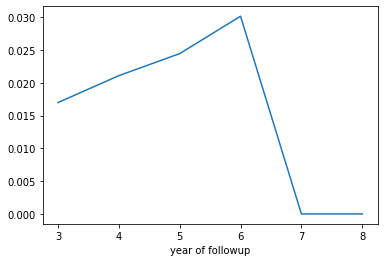

In [59]:
diabets_by_year['HNA'].plot()

**Вывод:** мы получили, что оценка Нельсона – Аалена максимальна на 6 году наблюдения, то есть вероятнее обнаружить заболевание по сравнению с другими годами. Но на самом деле эта кривая скорее всего должна рости, однако у нас нет достаточно данных обследований на 7-8 год наблюдения, чтобы получить соответствующую картину.

Оценка Нельсона – Аалена не персонализирована, т.е. для неё мы никак не использовали признаки пациентов.

Модель пропорциональных рисков Кокса (Cox Proportional Hazard Model, CPHM) моделирует отношение риска для пациента к среднему риску по всем пациентам для данного момента времени. Поскольку это отношение рисков – положительное число, его обычно моделируют как $e^{Xw}$, где $X$ – признаки пациентов, $w$ – обучаемый вектор весов. Таким образом,

$$\hat H_{Cox}(x, t) = \hat H_{NA}(t)e^{xw}.$$

Обратите внимание, что в линейной части CPHM не используют свободный член: в некотором смысле его роль играет $\hat H_{NA}(t)$.

Вероятность заболеть ровно в момент $t$ – это произведение вероятности не заболеть до момента $t$ на вероятность заболеть в момент $t$ при условии здоровья до момента $t$. Таким образом, функция правдоподобия имеет вид

$$L = \prod_{i=1}^N \left[(\hat H_{NA}(T_i)e^{x_iw})^{y_i}(1 - \hat H_{NA}(T_i)e^{x_iw})^{1-y_i}\prod_{t=0}^{T_i-1}\left(1-\hat H_{NA}(t)e^{x_iw}\right)\right],$$

где $T_i$ – момент последней записи, $i$-го пациента.
Максимизация правдоподобия эквивалентна минимизации «минус» нормированного логарифма правдоподобия.

$$\mathcal L = -\frac{1}{N}\log L = -\frac{1}{N}\sum_{i=1}^N\left[y_i\left(\log \hat H_{NA}(T_i) + x_iw\right) + (1-y_i)\left(\log (1-\hat H_{NA}(T_i) e^{x_iw})\right) + \sum_{t=0}^{T_i - 1}\log(1-\hat H_{NA}(t)e^{x_iw})\right]$$

$$\nabla_w\mathcal L = \frac{1}{N}\sum_{i=1}^N\left[-x_iy_i + (1-y_i)\frac{\hat H_{NA}(T_i)e^{x_iw}x_i}{1-\hat H_{NA}(T_i)e^{x_iw}} + \sum_{t=0}^{T_i-1}\frac{\hat H_{NA}(t)e^{x_iw}x_i}{1-\hat H_{NA}(t)e^{x_iw}}\right]$$

Минимизировать $\mathcal L$ можно градиентным спуском, итеративно применяя формулу

$$w:= w - \eta \nabla_w\mathcal L - \eta Cw$$

где $\eta > 0$ — размер шага (learning rate), $C\geq 0$ — коэффициент регуляризации.




**Задание 8** Cox Proportional Hazard Model (CPHM) (3 балла).

 Реализуйте градиентный спуск и примените его к модели CPHM.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).
- Рассмотрите регуляризованную модель (не менее 5-ти различных коэффициентов регуляризации), которая описана выше, а также модель без регуляризатора. Сравните, влияет ли наличие регуляризации на скорость сходимости и качество (под качеством во всех случаях подразумевается значение исходного, нерегуляризованного функционала).
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

В каждом пункте требуется построить необходимые графики скорости/качества и дать исчерпывающие выводы.


In [67]:
lab_train

,Age,Gender,site,height,weight,Body Mass Index,Systolic blood pressure,diastolic blood pressure,Fasting plasma glucose,Cholesterol,Triglyceride,High-density lipoprotein cholesterol,Low-density lipoprotein cholesterol,Alanine aminotransferase,Aspartate transaminase,Blood urea nitrogen,Creatinine clearance rate,Fasting plasma glucose (final visit),Diabetes diagnosed during followup,censor of diabetes at followup,year of followup,smoking status,drinking status,family history of diabetes
0,57.0,1.0,5.0,175.0,75.0,24.5,152.0,103.0,6.60,5.10,2.20,1.83,2.66,21.0,22.0,3.30,71.0,7.00,1.0,1.0,3.863107,3.0,3.0,0.0
1,48.0,2.0,9.0,164.0,53.2,19.8,118.0,54.0,4.50,3.70,1.15,1.34,2.70,27.7,22.0,3.20,55.4,4.60,0.0,0.0,2.472279,3.0,3.0,0.0
2,42.0,2.0,2.0,163.0,63.5,23.9,136.0,85.0,5.10,3.60,0.93,1.34,2.70,14.8,22.0,5.60,65.4,6.10,0.0,0.0,2.702259,3.0,3.0,0.0
3,43.0,2.0,5.0,160.0,59.0,23.0,112.0,89.0,4.52,3.87,1.00,1.55,1.89,12.0,20.0,4.55,49.0,5.40,0.0,0.0,4.043806,3.0,3.0,0.0
4,30.0,1.0,9.0,179.0,64.0,20.0,107.0,65.0,4.98,6.30,1.26,1.34,2.70,18.1,22.0,4.58,71.5,5.23,0.0,0.0,2.770705,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,58.0,1.0,4.0,173.0,68.0,22.7,134.0,83.0,5.28,4.14,2.97,0.83,2.38,12.9,22.0,5.14,90.0,5.12,0.0,0.0,2.934976,3.0,3.0,0.0
79996,39.0,2.0,4.0,155.0,56.0,23.3,120.0,65.0,5.68,4.19,1.24,1.34,2.70,10.7,22.0,3.68,56.6,5.60,0.0,0.0,2.759754,3.0,3.0,0.0
79997,25.0,1.0,7.0,168.5,74.0,26.1,123.0,71.0,4.00,5.13,0.93,1.56,3.08,23.5,26.8,4.60,79.6,4.54,0.0,0.0,2.264203,3.0,3.0,0.0
79998,35.0,2.0,3.0,157.5,52.0,21.0,104.0,78.0,4.29,5.08,0.57,1.34,2.70,22.5,22.0,4.53,69.4,4.25,0.0,0.0,3.572895,3.0,3.0,0.0


In [77]:
def get_hna(t):
    if t not in diabets_by_year.index:
        return 0.

    return diabets_by_year[diabets_by_year.index == t]['HNA'].values[0]

In [78]:
def get_log_loss(X, y, w, t):
    loss = 0.
    for x, y in zip(X, y):
        xw = np.multiply(x, w).sum()
        hna = get_hna(t)

        prob_before = 0.
        for i in range(t):
            hna_i = get_hna(i)
            prob_before +=np.log(1 - hna_i * np.exp(xw))
            
        loss += y * (np.log(hna) + xw) + (1 - y) * (log(1 - hna * np.exp(xw))) + prob_before
    return - loss / X.shape[0]

In [79]:
def get_gradient(x, y, w, t):
    hna = get_hna(t)
    exp_xw = np.exp(np.multiply(x, w).sum())
    h_cox = hna * exp_xw

    h_cox_before = 0.
    for i in range(t):
        hna_i = get_hna(i)
        h_cox_before += hna_i * exp_xw / (1 - hna_i * exp_xw) * x

    return -x * y + (1 - y) * h_cox / (1 - h_cox) * x + h_cox_before

In [80]:
def CPHM(X, y, w, t, max_iter = 10 ** 4, nu=0.1, eps = 1e-4, C=0):
    n = X.shape[0]
    log_losses = []
    for iter in range(max_iter):
        grad = np.zeros_like(w)
        for i in range(n):
            np.add(grad, get_gradient(X[i], y[i], w, t), out=grad)
        grad = grad / n
        
        w_new = w - nu * grad - nu * C * w
        w_eps = np.subtract(w, w_new)
        w = w_new

        log_losses.append(get_log_loss(X, y, w, t))

        if np.multiply(w_eps, w_eps).sum() < eps:
            break
        return log_losses

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту.

**Задание 9** SGD (1 балл)

Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы мож
ете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов.

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений)
Исследуйте качество оптимизируемого функционала в зависимости от номера итерации
Выберите лучший размер шага.

В каждом пункте сделайте исчерпывающие выводы, подкреплённые графиками.

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{w}{J(w)}$$
$$ w = w - v_t$$

где

 - $w$ — вектор параметров
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $w_i$ на итерации $t$ как $g_{t,i} = \nabla_{w}J(w_i)$. 

В случае sgd обновление параметра $w_i$ будет выглядеть следующим образом:

$$ w_{t+1, i} = w_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ w_{t+1, i} = w_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $w_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ w_{t+1} = w_{t} + \Delta w_t$$ 
$$\Delta w_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $w$:

$$ E[\Delta w^2]_t = \gamma E[\Delta w^2]_{t-1} + (1-\gamma)\Delta w^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta w_t = - \dfrac{RMS[\Delta w^2]}{RMS[ga^2]} g_t $$ 
$$ w_{t+1} = w_{t} + \Delta w_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

**Задание 10** Реализуйте метод оптимизации *Momentum* (0.5 балла) и 

**Задание 11** Реализуйте один из *Adagrad*/*Adadelta* (1 балл).

В заданиях 10, 11:
- Сравните оба метода с классическим sgd с точки зрения скорости сходимости.
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.

Постройте графики и опишите полученные результаты.

Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

**Задание 12** Предсказание с помощью CPHM, интерфейс sklearn (1 балл)


Чтобы сравнить CPHM с предыдущими моделями, надо научиться предсказывать целевую переменную. С помощью значений персональной функции риска $\hat H_{Cox}(x, t)$ можно выразить вероятность того, что человек в течение 5 лет не заболеет при условии, что он не прекратит участие в эксперементе по другим причинам. Вероятность того, что человек не прекратит участие в эксперименте, оставаясь здоровым, также можно оценить из данных.

Реализуйте модель CPHM, унаследовав класс модели от [BaseEstimator](https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator). Модель должна поддерживать методы fit, predict, predict_proba. Это вам позволит в следующем задании её откалибровать. При тестировании модели следует передать то время, через которое вас интересует состояние пациента (в случае конкурса, 5 лет).




**Задание 13** Калибровка классификатора (2 балла)

Сравнительно простой способ уточнить оценки вероятности и уменьшить logloss -- откалибровать модель. Вообще говоря, сравнивать между собой некалиброванные модели по logloss некорректно: хорошая модель с нарушенной калибровкой может иметь сколь угодно большое значение logloss.

Идея калибровки состоит в том, чтобы подобрать простое преобразование, которое превратит выходы моделей в вероятности принадлежности классам.

Есть несколько известных методов калибровки:
 - Калибровка Платта.
 - Изотоническая регрессия.

Обратите внимание, что преобразование необходимо обучать на отложенной выборке (то есть классификатор и калибровка должны обучаться на разных подмножествах данных), иначе можно переобучиться. Калибровку можно применять к любым классификаторам (где это разумно и необходимо), особенно к тем, которые не оптимизируют logloss явно.

Для калибровки классификатора в sklearn возможны два подхода:
 - взять уже обученный классификатор и откалибровать его на отложенной выборке
 - откалибровать по кросс-валидации: калибровочному классификатору передается вся обучающая выборка, которая внутри разбивается на обучающую и калибровочную, после чего происходит усреднение вероятностей по фолдам.
 
Подробнее об этом можно прочитать в [документации](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV). Также [здесь](https://jmetzen.github.io/2015-04-14/calibration.html) можно узнать подробности о калибровке в sklearn от автора.

Используйте оба описанных выше подхода (калибровку Платта и изотоническую регрессию) для калибровки моделей, построенных в лабораторной работе. Для каждой модели постройте график, на котором будут изображены [калибровочные кривые](http://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html): идеальная, исходного классификатора, а также для каждого из методов. Калибровочная кривая строится путем упорядочения всех объектов по предсказанному значению, которые разбиваются на бины. По оси OX откладывается среднее предсказанное значение вероятности по бину, а по OY — доля положительных примеров. В случае идеальных вероятностей это будет прямая.
 


Выполнив задания, не забудьте отправить решение в [конкурс](https://www.kaggle.com/c/competition-2-yandex-shad-spring-2021)

**Выводы** (0.5 балла)

- Какие есть достоинства и недостатки у рассмотренных в лабораторной работе моделей?
- Какие модели сильно улучшили свой logloss после калибровки, а какие - нет? Почему так произошло?
- Какие из рассмотренных методов могут обучиться на маленьких датасетах? А какие применимы для очень больших датасетов? Какие проблемы могут возникнуть при применении к большим датасетам и как их можно решить?
